In [1]:
ENV["GKS_ENCODING"] = "utf-8"
using Plots
using LadderDGA
using Logging

io = stdout
metafmt(level::Logging.LogLevel, _module, group, id, file, line) = Logging.default_metafmt(level, nothing, group,     id, nothing, nothing)
logger = ConsoleLogger(io, Logging.Info, meta_formatter=metafmt, show_limited=true, right_justify=0)
global_logger(logger);

┌ Info: Precompiling LadderDGA [78e40beb-bf89-4c0e-9d2b-bee278912f2b]
└ @ Base loading.jl:1423


# Setup and read DMFT quantities

In [2]:
using TimerOutputs

using Pkg
Pkg.activate("/home/julian/Hamburg/Julia_lDGA/LadderDGA.jl")
using LadderDGA

cfg_file =  "/home/julian/Hamburg/Julia_lDGA/lDGA_shift_tests/data/40_40_s0_b14_u1.0/config_j.toml";
mP, sP, env, kGridsStr = readConfig(cfg_file);

impQ_sp, impQ_ch, gImp, kGridLoc, kG, gLoc, gLoc_fft, Σ_loc, FUpDo = setup_LDGA(kGridsStr[1], mP, sP, env);
@info "local"
bubbleLoc = calc_bubble(gImp, kGridLoc, mP, sP);
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubbleLoc, kGridLoc, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubbleLoc, kGridLoc, -mP.U, mP, sP);


Σ_ladderLoc = calc_Σ(locQ_sp, locQ_ch, bubbleLoc, gImp, FUpDo, kGridLoc, mP, sP)
Σ_ladderLoc = Σ_ladderLoc .+ mP.n * mP.U/2.0;

# ladder quantities
@info "bubble"
bubble = calc_bubble(gLoc_fft, kG, mP, sP);
@info "chi"
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, kG, mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, kG, -mP.U, mP, sP);
@info "Σ"
Σ_ladder = calc_Σ(nlQ_sp, nlQ_ch, bubble, gLoc_fft, FUpDo, kG, mP, sP)
Σ_ladder = Σ_loc_correction(Σ_ladder,Σ_ladderLoc,Σ_loc);

[ Info: Reading Inputs...
[ Info: Setting up calculation for kGrid 3Dsc-0.2041241452319315 of size 4
[ Info: setting usable ranges of sp and ch channel from 28:54 and 28:54 to the same range of 28:54
[ Warning: TODO: update local omega sum with correction
[ Warning: using unoptimized sum_freq
[ Warning: using unoptimized sum_freq
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(28:54) = 0.2147, χLoc_ch(28:54) = 0.1365
└ sum χupup check (fit, tail sub, tail sub + fit, expected): 0.1755788445327572 ?≈? 0.21520636358989342 ?=? 0.21520636358989342 ?≈? 0.25"
[ Info: local
[ Info: bubble
[ Info: chi
[ Info: Σ


  Activating project at `~/Hamburg/Julia_lDGA/LadderDGA.jl`


In [3]:
println("Compare with energies_dmft_nusum.dat, column 3 and 5, last line")
iνₙ = LadderDGA.iν_array(mP.β, 0:(sP.n_iν-1))
iνₙ, GImp    = LadderDGA.readGImp(env.inputDir * "/gm_wim", only_positive=true)
ϵₖ, Vₖ, μ    = LadderDGA.read_anderson_parameters(env.inputDir * "/hubb.andpar");
E_kin_ED, E_pot_ED  = LadderDGA.calc_E_ED(iνₙ[1:20], ϵₖ, Vₖ, GImp[1:20], mP)
E_kin_ED_large, E_pot_ED_large  = LadderDGA.calc_E_ED(iνₙ[1:5000], ϵₖ, Vₖ, GImp[1:5000], mP)

Compare with energies_dmft_nusum.dat, column 3 and 5, last line


(-0.7546239818666916, 0.20374739512350937)

In [4]:
ep_loc, ek_loc = LadderDGA.calc_E(Σ_loc[:,1:sP.n_iν], kG, mP, sP);

LoadError: BoundsError: attempt to access 162-element Vector{ComplexF64} at index [1:162, 1:40]

In [5]:
iν_array = LadderDGA.iν_array
G_from_Σ = LadderDGA.G_from_Σ
flatten_2D = LadderDGA.flatten_2D

Σ = Σ_ladder
νmax = size(Σ,2)
νGrid = 0:(νmax-1)
iν_n = iν_array(mP.β, νGrid)
Σ_hartree = mP.n * mP.U/2
Σ_corr = Σ .+ Σ_hartree

E_kin_tail_c = [zeros(size(kG.ϵkGrid)), (kG.ϵkGrid .+ Σ_hartree .- mP.μ)]
E_pot_tail_c = [zeros(size(kG.ϵkGrid)),
                (mP.U^2 * 0.5 * mP.n * (1-0.5*mP.n) .+ Σ_hartree .* (kG.ϵkGrid .+ Σ_hartree .- mP.μ))]
tail = [1 ./ (iν_n .^ n) for n in 1:length(E_kin_tail_c)]
E_pot_tail = sum(E_pot_tail_c[i] .* transpose(tail[i]) for i in 1:length(tail))
E_kin_tail = sum(E_kin_tail_c[i] .* transpose(tail[i]) for i in 1:length(tail))
E_pot_tail_inv = sum((mP.β/2)  .* [Σ_hartree .* ones(size(kG.ϵkGrid)), (-mP.β/2) .* E_pot_tail_c[2]])
E_kin_tail_inv = sum(map(x->x .* (mP.β/2) .* kG.ϵkGrid , [1, -(mP.β) .* E_kin_tail_c[2]]))

@warn "possible bug in flatten_2D with new axis, use calc_E_pot, calc_E_kin instead"
G_corr = transpose(flatten_2D(G_from_Σ(Σ_corr, kG.ϵkGrid, νGrid, mP)));
E_pot_full = real.(G_corr .* Σ_corr .- E_pot_tail);
E_kin_full = kG.ϵkGrid .* real.(G_corr .- E_kin_tail);
#E_pot_tail_inv
#E_kin_tail_inv
t = 0.5*kintegrate(kG, Σ_hartree .* ones(length(kG.kMult)))
E_pot = [kintegrate(kG, 2 .* sum(E_pot_full[:,1:i], dims=[2])[:,1] .+ E_pot_tail_inv) for i in 1:νmax] ./ mP.β
E_kin = [kintegrate(kG, 4 .* sum(E_kin_full[:,1:i], dims=[2])[:,1] .+ E_kin_tail_inv) for i in 1:νmax] ./ mP.β;

[ Warning: possible bug in flatten_2D with new axis, use calc_E_pot, calc_E_kin instead


In [6]:
E_kin

40-element Vector{Float64}:
 -0.40386947986245864
 -0.2892353809165824
 -0.25989552844586755
 -0.24925155300043317
 -0.2445641952409264
 -0.242213429138388
 -0.24091720351281704
 -0.2401486745466213
 -0.23966614725843596
 -0.23934881953609533
 -0.23913200654808128
 -0.23897905292547067
 -0.23886817812079905
  ⋮
 -0.23848518465319662
 -0.23848138858891232
 -0.23847806120695234
 -0.23847513190915048
 -0.23847254243651128
 -0.23847024445374543
 -0.23846819770384142
 -0.23846636864173837
 -0.2384647295680617
 -0.2384632584673579
 -0.23846194031458007
 -0.238460772693047

In [7]:
E_pot

40-element Vector{Float64}:
 0.010528697147643111
 0.04472763295057478
 0.04480609550804776
 0.040311877621191816
 0.035693511890049275
 0.03171730797006362
 0.02842117405418523
 0.025700387148712842
 0.023440373741583507
 0.021544945071441834
 0.019938736439657788
 0.018563825773061364
 0.01737575944840381
 ⋮
 0.00901649309747796
 0.008779103292173305
 0.008556326648568369
 0.008346782984566354
 0.008149252691348252
 0.00796266232696774
 0.007786084985654977
 0.007618768434481663
 0.007460230698234914
 0.007310523368650825
 0.0071709623912072406
 0.007046383640062969

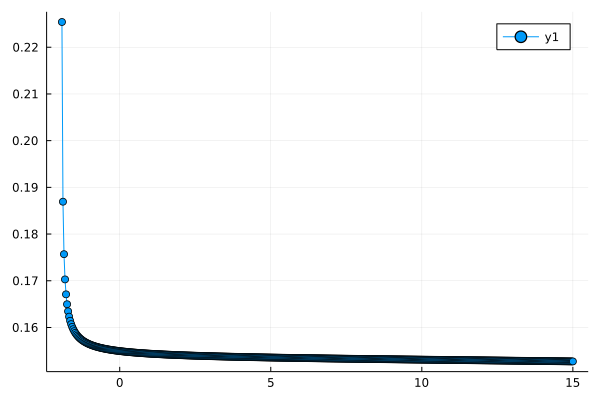

In [56]:
include("/home/julian/Hamburg/Julia_lDGA/LadderDGA_utils.jl/new_lambda_analysis.jl")
λch_range_f, spOfch_f = λsp_of_λch(nlQ_sp, nlQ_ch, kG, mP, sP; max_λsp=50.0, λch_max=15.0, n_λch=500)
rr = filter_usable_λsp_of_λch(λch_range_f, spOfch_f)
λch_range = λch_range_f[rr]
spOfch = spOfch_f[rr]
plot(λch_range, spOfch, markershape=:circle)

In [57]:
res_c2 = c2_along_λsp_of_λch(λch_range, spOfch, nlQ_sp, nlQ_ch, bubble,
    Σ_ladderLoc, Σ_loc, gLoc_fft, FUpDo, kG, mP, sP)

499×6 Matrix{Float64}:
 0.225407  -1.91273  0.25  0.25   0.0171764  -0.181631
 0.186928  -1.87877  0.25  0.25  -0.0136626  -0.196594
 0.175694  -1.84481  0.25  0.25  -0.0315718  -0.205256
 0.170291  -1.81085  0.25  0.25  -0.0451911  -0.211737
 0.167095  -1.77689  0.25  0.25  -0.0564698  -0.217012
 0.164973  -1.74293  0.25  0.25  -0.066183   -0.221484
 0.163458  -1.70896  0.25  0.25  -0.0747383  -0.225368
 0.162318  -1.675    0.25  0.25  -0.0823872  -0.228797
 0.161428  -1.64104  0.25  0.25  -0.089301   -0.231862
 0.160713  -1.60708  0.25  0.25  -0.0956038  -0.234629
 0.160124  -1.57312  0.25  0.25  -0.101389   -0.237146
 0.15963   -1.53916  0.25  0.25  -0.106731   -0.239451
 0.15921   -1.5052   0.25  0.25  -0.111688   -0.241574
 ⋮                                            ⋮
 0.15276   14.6264   0.25  0.25  -0.339709   -0.333108
 0.152757  14.6604   0.25  0.25  -0.339996   -0.333228
 0.152754  14.6943   0.25  0.25  -0.340285   -0.333348
 0.152752  14.7283   0.25  0.25  -0.340574   -0.3

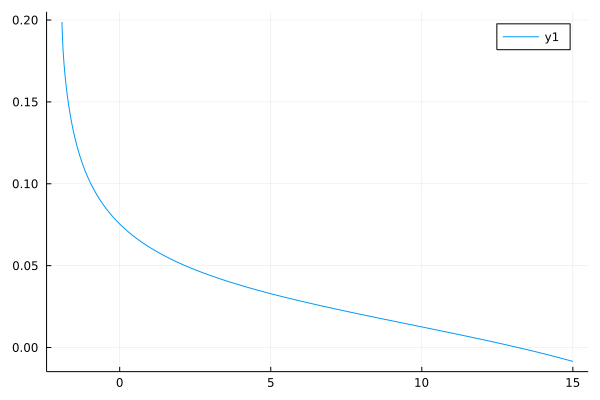

In [58]:
plot(λch_range, res_c2[:,5] .- res_c2[:,6])

In [12]:
nlQ_sp_λ = deepcopy(nlQ_sp);
nlQ_sp_λ.λ = spOfch[end]
nlQ_sp_λ.χ = LadderDGA.χ_λ(nlQ_sp.χ, spOfch[end]);
Σ_ladder_λ = calc_Σ(nlQ_sp_λ, nlQ_ch, bubble, gLoc_fft, FUpDo, kG, mP, sP)
Σ_ladder_λ = Σ_loc_correction(Σ_ladder_λ,Σ_ladderLoc,Σ_loc);

In [30]:
E_kin, E_pot = LadderDGA.calc_E(Σ_ladder_λ, kG, mP, sP);
(E_pot./mP.U .- (mP.n/2) * (mP.n/2))

[ Warning: possible bug in flatten_2D with new axis, use calc_E_pot, calc_E_kin instead


40-element Vector{Float64}:
 -0.24891338577961714
 -0.22262357688591133
 -0.22761397517430593
 -0.23553651963875122
 -0.24259701328241004
 -0.24838466959260852
 -0.2530687134429045
 -0.25688166519988076
 -0.26002055787992745
 -0.26263676901523747
 -0.2648437662825578
 -0.2667264976558407
 -0.26834904459285747
  ⋮
 -0.2796745580980744
 -0.27999392200417983
 -0.2802934315978944
 -0.28057494925143156
 -0.28084011839730616
 -0.2810903858667152
 -0.2813270076043278
 -0.28155102572281365
 -0.2817631752797706
 -0.2819636202881495
 -0.28215121532537496
 -0.28232122104400925

In [45]:
xupup = kintegrate(kG, real.(nlQ_ch.χ .+ nlQ_sp_λ.χ), 1)[1,:] ./ (2)
iωn = 1im .* 2 .* (-sP.n_iω:sP.n_iω) .* π ./ mP.β
xupup = LadderDGA.subtract_tail(xupup, mP.Ekin_DMFT, iωn)
xupup = sum(xupup) / mP.β - mP.Ekin_DMFT*mP.β/12

0.21749275284688863

In [13]:
nlQ_ch.γ[:,40,41]

10-element Vector{ComplexF64}:
 0.7488039540800255 - 5.6199551715752806e-9im
 0.8181748064351114 - 3.589513281450801e-9im
 0.7582653432147911 - 6.369175004909619e-9im
 0.7931039823162078 - 6.08530122879078e-9im
  0.758265343214791 - 6.3691750103849e-9im
 0.7931039823162077 - 6.085301232067452e-9im
 0.7262271996435677 - 9.10207003172385e-9im
 0.7262271996435676 - 9.102070029276389e-9im
 0.7507683892807774 - 9.623841523436265e-9im
 0.6236329353752598 - 1.444101633047643e-8im

In [14]:
E_kin_full .* 2

10×40 Matrix{Float64}:
 58.1117        5.49001       1.53657      …  8.30568e-5    7.4055e-5
 25.5172        2.19326       0.562249        2.46158e-5    2.18044e-5
  6.02121       0.468565      0.110804        4.30102e-6    3.77771e-6
 -1.88818e-23  -4.49917e-24  -4.39865e-25     5.73589e-27  -8.73081e-28
  6.02121       0.468565      0.110804        4.30102e-6    3.77771e-6
 -1.14117e-23  -2.7192e-24   -2.65844e-25  …  3.46664e-27  -5.27671e-28
  6.02121       0.468565      0.110804        4.30096e-6    3.77772e-6
  6.02121       0.468565      0.110804        4.30096e-6    3.77772e-6
 25.5172        2.19326       0.562249        2.46157e-5    2.18044e-5
 58.1117        5.49001       1.53657         8.30566e-5    7.4055e-5

In [15]:
E_kin

40-element Vector{Float64}:
 -0.40386947986245864
 -0.2892353809165824
 -0.25989552844586755
 -0.24925155300043317
 -0.2445641952409264
 -0.242213429138388
 -0.24091720351281704
 -0.2401486745466213
 -0.23966614725843596
 -0.23934881953609533
 -0.23913200654808128
 -0.23897905292547067
 -0.23886817812079905
  ⋮
 -0.23848518465319662
 -0.23848138858891232
 -0.23847806120695234
 -0.23847513190915048
 -0.23847254243651128
 -0.23847024445374543
 -0.23846819770384142
 -0.23846636864173837
 -0.2384647295680617
 -0.2384632584673579
 -0.23846194031458007
 -0.238460772693047

In [16]:
E_pot .* 4

40-element Vector{Float64}:
 0.042114788590572445
 0.17891053180229913
 0.17922438203219104
 0.16124751048476726
 0.1427740475601971
 0.12686923188025448
 0.11368469621674092
 0.10280154859485137
 0.09376149496633403
 0.08617978028576734
 0.07975494575863115
 0.07425530309224546
 0.06950303779361525
 ⋮
 0.03606597238991184
 0.03511641316869322
 0.034225306594273475
 0.03338713193826542
 0.03259701076539301
 0.03185064930787096
 0.03114433994261991
 0.030475073737926652
 0.029840922792939657
 0.0292420934746033
 0.028683849564828962
 0.028185534560251874

In [17]:
subtract_tail = LadderDGA.subtract_tail
iωn = 1im .* 2 .* (-sP.n_iω:sP.n_iω)[usable_ω] .* π ./ mP.β
plot(real(subtract_tail(impQ_sp.χ_ω[usable_ω], E_kin_ED_large,iωn)), markershape=:circle)
plot!(real(subtract_tail(impQ_ch.χ_ω[usable_ω], E_kin_ED_large, iωn )), markershape=:hexagon)
plot!(real(subtract_tail(0.5*(impQ_sp.χ_ω .+ impQ_ch.χ_ω )[usable_ω], E_kin_ED_large, iωn)))

LoadError: cannot assign a value to variable LadderDGA.subtract_tail from module Main